In [1]:
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
import tcod

In [2]:
game_map =  tcod.map.Map(width=80, height=45)

In [9]:
def irregular_shape(w=10, h=10):
    angle = np.linspace(0, 2 * np.pi, 100)

    # circle coordinates
    r_circle = np.sqrt((w/2)**2 + (h/2)**2)
    x = np.round(np.cos(angle)*r_circle, 2)
    y = np.round(np.sin(angle)*r_circle, 2)

    # rectangle coordinates
    x[x > w/2] = w/2
    x[x < -w/2] = -w/2
    y[y > h/2] = h/2
    y[y < -h/2] = -h/2
    
    # noise for x coordinate
    noise1 = tcod.noise.Noise(
        dimensions=1,
        algorithm=tcod.NOISE_SIMPLEX,
        implementation=tcod.noise.FBM,
        hurst=0.5,
        lacunarity=2,
        octaves=4,
    )
    
    # noise for y coordinate
    noise2 = tcod.noise.Noise(
        dimensions=1,
        algorithm=tcod.NOISE_SIMPLEX,
        implementation=tcod.noise.FBM,
        hurst=0.5,
        lacunarity=2,
        octaves=4,
    )

    # Return the sampled noise from the grid of points.
    xn = noise1.sample_ogrid([angle])
    yn = noise2.sample_ogrid([angle])

    # start and end return to zero
    xn[:20] = xn[:20] * np.arange(0, 1, 0.05)
    xn[-20:] = xn[-20:] * np.arange(1, 0, -0.05)
    yn[:20] = yn[:20] * np.arange(0, 1, 0.05)
    yn[-20:] = yn[-20:] * np.arange(1, 0, -0.05)

    # add noise 
    x = x + x * xn
    y = y + y * yn

    # move origin point
    x = x - min(x) + 3
    y = y - min(y) + 4
    
    # update width, height
    w = int(max(x) + 5)
    h = int(max(y) + 7)
    
    # draw to numpy array
    img = np.zeros((h, w), dtype=np.int)
    rr, cc = skimage.draw.polygon(y, x)
    img[rr, cc] = True
    return img

In [ ]:
def apply_tileset():
    # move room in all direction, use the mask as the wall
    # to create the 3d effect, move picture north and south by 2
    floor = img[2:-2, 2:-2]
    nw_roof = floor < img[3:-1, 3:-1]
    ne_roof = floor < img[3:-1, 1:-3]
    sw_roof = floor < img[1:-3, 3:-1]
    se_roof = floor < img[1:-3, 1:-3]
    n_roof = floor < img[3:-1, 2:-2]
    s_roof = floor < img[1:-3, 2:-2]
    w_roof = floor < img[2:-2, 3:-1]
    e_roof = floor < img[2:-2, 1:-3]
    lnw_roof = floor < img[4:, 3:-1]
    lne_roof = floor < img[4:, 1:-3]
    lsw_roof = floor < img[:-4, 3:-1]
    lse_roof = floor < img[:-4, 1:-3]
    ln_roof = floor < img[4:, 2:-2]
    ls_roof = floor < img[:-4, 2:-2]
    w_roof = floor < img[2:-2, 3:-1]
    e_roof = floor < img[2:-2, 1:-3]

    roof_wall = (
        ln_roof + lnw_roof + lne_roof + 
        ls_roof + lsw_roof + lse_roof + 
        n_roof + nw_roof + ne_roof +
        s_roof + sw_roof + se_roof + 
        e_roof + w_roof
    )
    
    # create wall and roof
    final = roof_wall[:-1] << roof_wall[1:]
    final = final.astype(np.int16)

    # remove wall with no roof
    wall_with_no_roof = (final == 1)[1:-1,1:-1] & (final == 0)[0:-2,1:-1]
    final[1:-1,1:-1][wall_with_no_roof] = 0
    
    # change number to tileset
    final[(floor[:-1] == 1)] = 249 # floor
    final[final == 1] = 176 # wall
    final[final == 2] = 219 # roof
    
    return roof_wall

In [10]:
def show(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

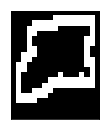

In [11]:
img = irregular_shape()
img = apply_tileset(img)
show(img)

In [7]:
img.shape

(17, 17)

In [8]:
game_map.walkable[:20, :15].shape

(20, 15)